<a href="https://colab.research.google.com/github/miltiadiss/Decision-Theory/blob/main/TSLA_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
desired_directory = '/content/drive/MyDrive/alphavantage' #define current directory in google drive
os.chdir(desired_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import requests

#API_KEY = YZFYJ9DASTWXPXOS
#STOCK_SYMBOL = TSLA

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=TSLA&outputsize=full&apikey=YZFYJ9DASTWXPXOS'
r = requests.get(url)
json_data = r.json()

#print(json_data)

Data saved to close_prices.csv


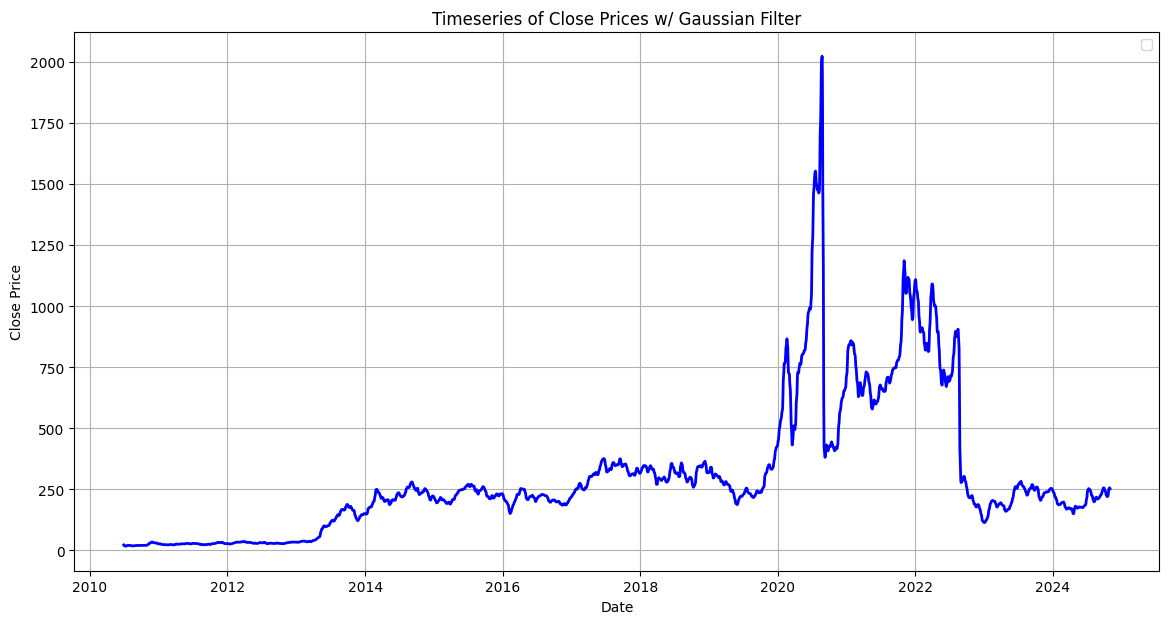

In [16]:
import json
import csv
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt

# Extract "Time Series (Daily)" part from JSON
time_series = json_data.get("Time Series (Daily)", {})

# Prepare data for CSV
csv_data = [("Date", "Close")]  # Header for CSV file

# Loop through each date and get the "close" price
for date, daily_data in time_series.items():
    close_price = daily_data.get("4. close", None)
    if close_price:
        csv_data.append((date, close_price))

# Write data to CSV file
csv_file = 'close_prices.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Data saved to {csv_file}")

# Read CSV file and store the data in a DataFrame
df = pd.read_csv('close_prices.csv', parse_dates=['Date'])
df = df.sort_values(by='Date')  # Sorting by 'Date'

# Apply Gaussian Filter in 'Close' prices for smoothing
sigma = 2
df['Close'] = gaussian_filter1d(df['Close'], sigma=sigma)

# Plot the smoothed timeseries
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], color='blue', linewidth=2)

plt.title('Timeseries of Close Prices w/ Gaussian Filter')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

### **Observation**
TSLA stock closing prices exhibit a strong upward trend starting around 2019, which peaks in late 2021 before experiencing a significant drop in 2022. This is a typical pattern seen in many high-growth stocks, where a sharp increase is followed by a correction. There are periods of high volatility, particularly during the 2020-2022 period, with sharp spikes and drops. This suggests that the stock had frequent fluctuations. After the significant drop in 2022, the closing prices seem to have stabilized, hovering around a lower price range in 2023-2024. Overall, if we use as a training set all the closing prices until 2023-12-31, then the training data cannot be described as steady due to the sharp peaks and corrections. On the other hand, they are characterized by high volatility and periodic corrections.







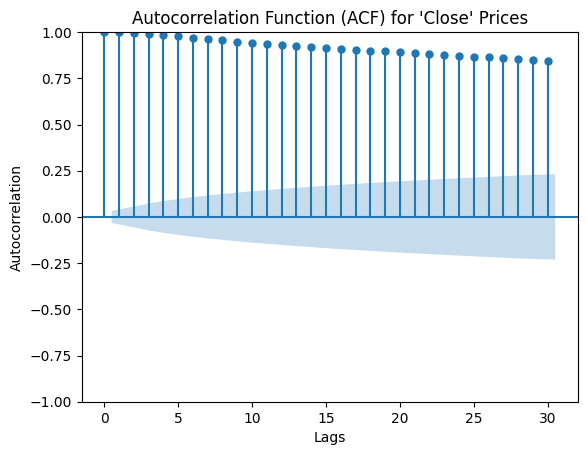

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

# Create ACF plot to find related lags
plot_acf(df['Close'], lags=30)
plt.title("Autocorrelation Function (ACF) for 'Close' Prices")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

### **Observation**
We observe that the lagged features (daily closing prices) have a high Autocorrelation Function (ACF), which suggests that past values have a strong correlation with future values, indicating a persistence in the data or a strong trend. Lagged daily features will retain the fine-grained details that help capture these dependencies more accurately. With high ACF, sudden changes or trends in the daily prices (like upward or downward trends) are likely to carry forward. Daily lagged values would capture these shifts more directly than weekly values, which tend to smooth over such changes, potentially missing short-term predictive information. Therefore, since our training data indicate great volatility and instability, we will choose to use the daily closing prices as features for the training of the model rather than the weekly averages.

However, we will provide the model with both cases of lagged features in order to showcase the difference in the validation after the training.

#**Training, Validation and Testing of Linear Regression Model**

##**Using daily closing prices as lagged features**


Model Parameters for N=1:
Bias: 0.4456
Weight for close_t-1: 0.9988
Model Equation:
Close_t = 0.4456 + (0.9988) * close_t-1

Model Parameters for N=2:
Bias: 0.6602
Weight for close_t-1: 1.9376
Weight for close_t-2: -0.9398
Model Equation:
Close_t = 0.6602 + (1.9376) * close_t-1 + (-0.9398) * close_t-2

Model Parameters for N=3:
Bias: 0.0850
Weight for close_t-1: 2.7736
Weight for close_t-2: -2.6631
Weight for close_t-3: 0.8893
Model Equation:
Close_t = 0.0850 + (2.7736) * close_t-1 + (-2.6631) * close_t-2 + (0.8893) * close_t-3

Model Parameters for N=4:
Bias: 0.1331
Weight for close_t-1: 3.4860
Weight for close_t-2: -4.7965
Weight for close_t-3: 3.1111
Weight for close_t-4: -0.8010
Model Equation:
Close_t = 0.1331 + (3.4860) * close_t-1 + (-4.7965) * close_t-2 + (3.1111) * close_t-3 + (-0.8010) * close_t-4

Model Parameters for N=5:
Bias: 0.0313
Weight for close_t-1: 4.1241
Weight for close_t-2: -7.2746
Weight for close_t-3: 6.9314
Weight for close_t-4: -3.5774
Weight for close_t-5: 

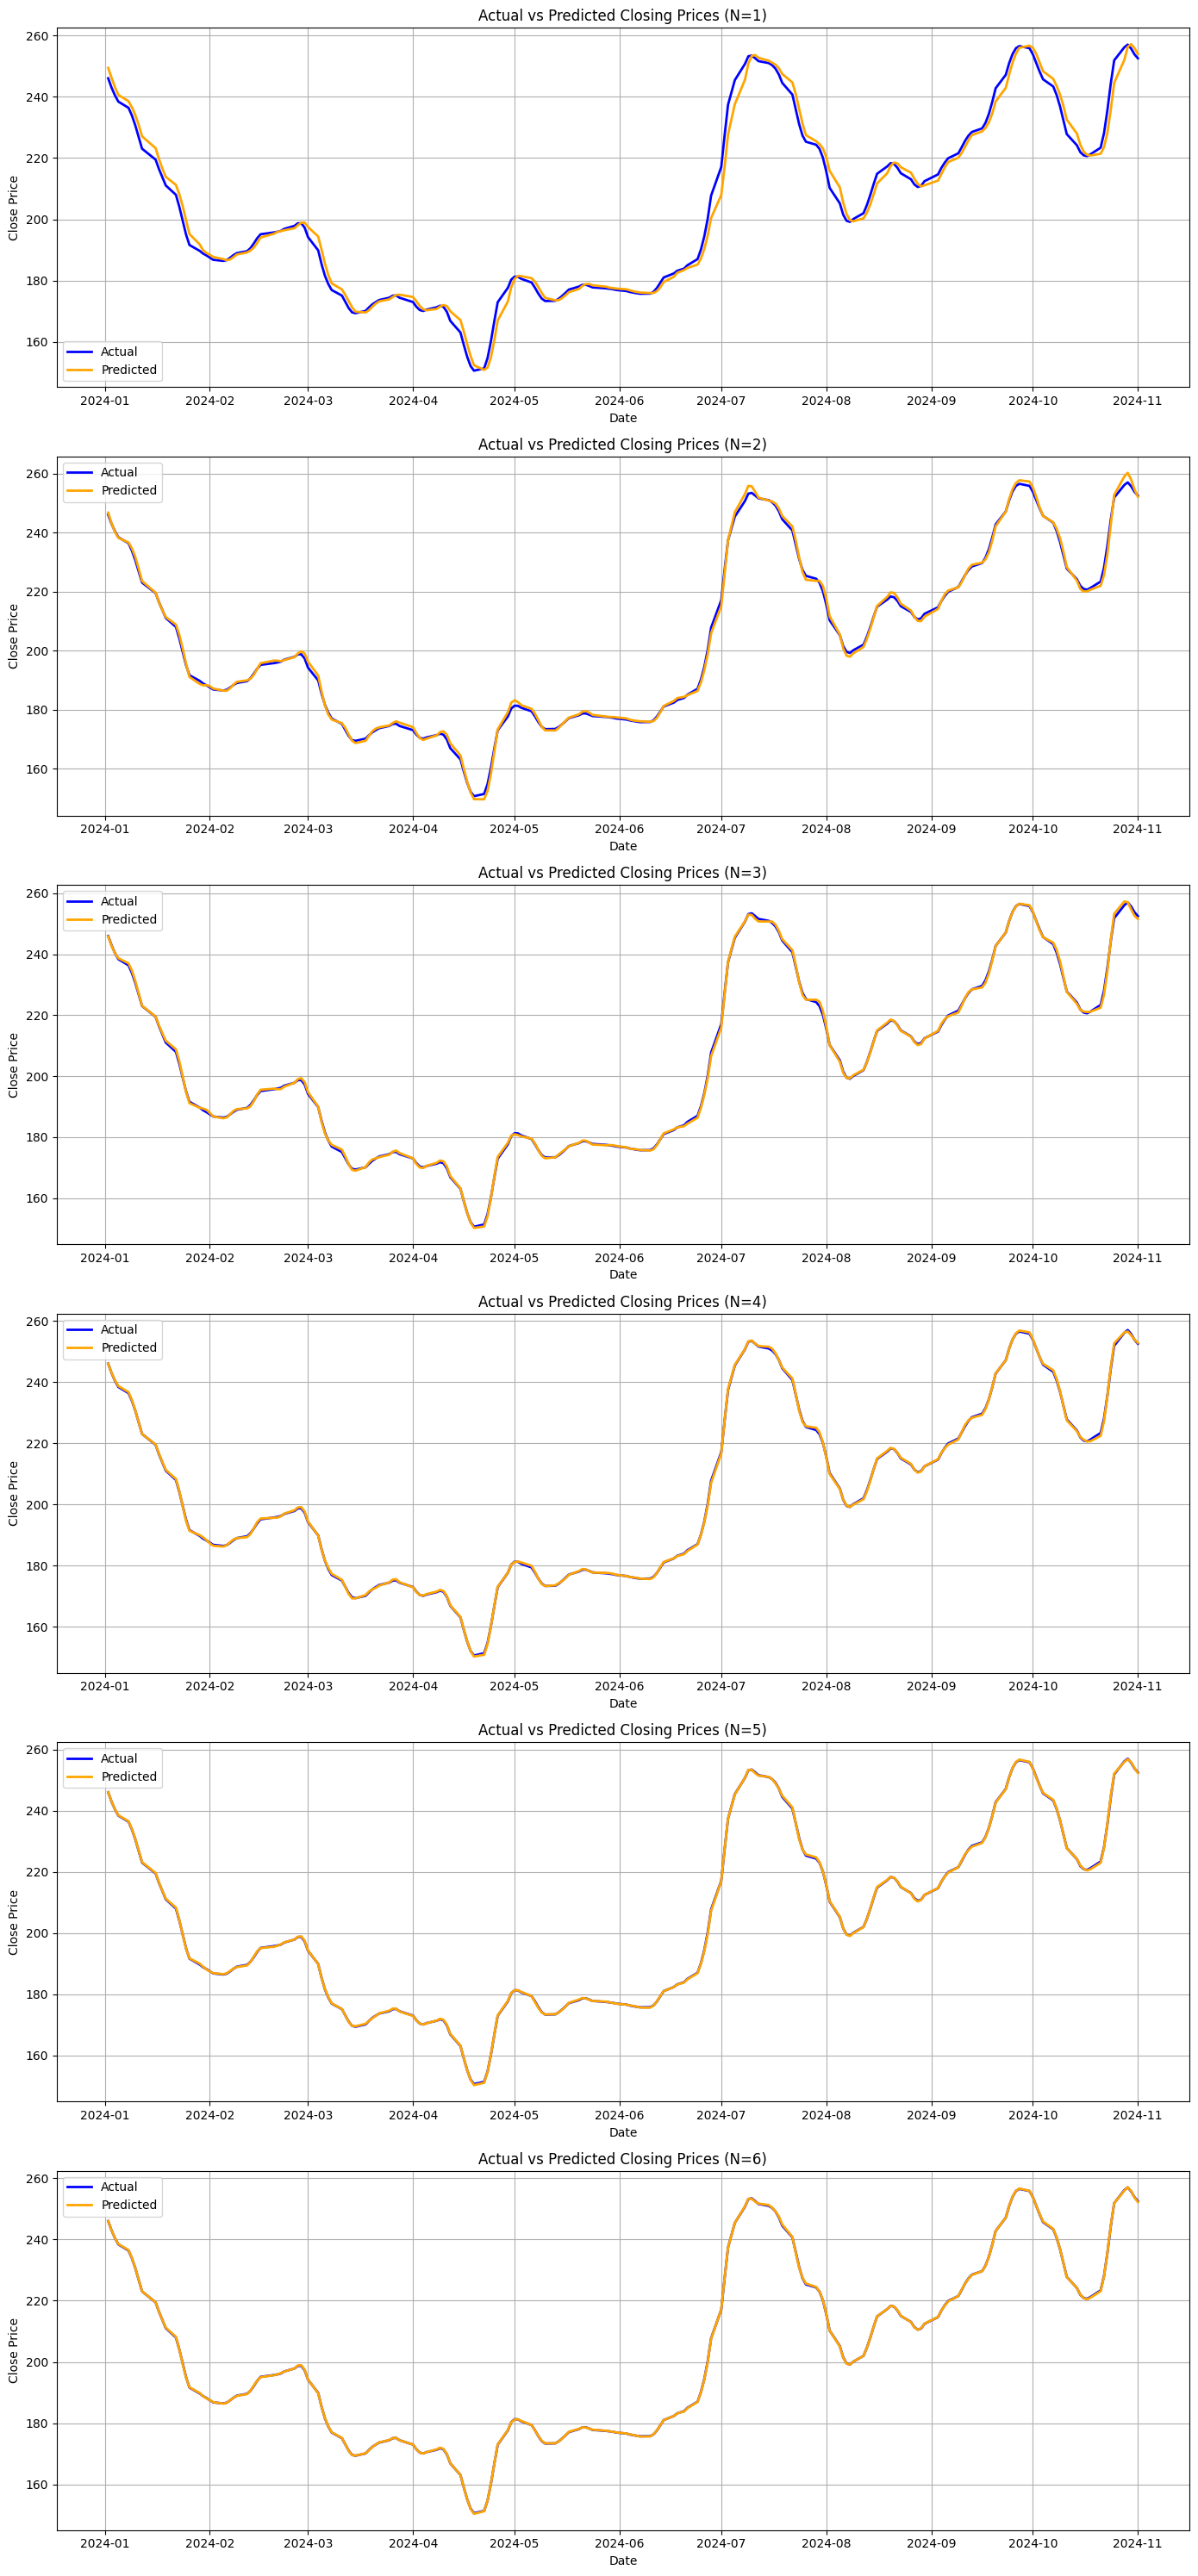

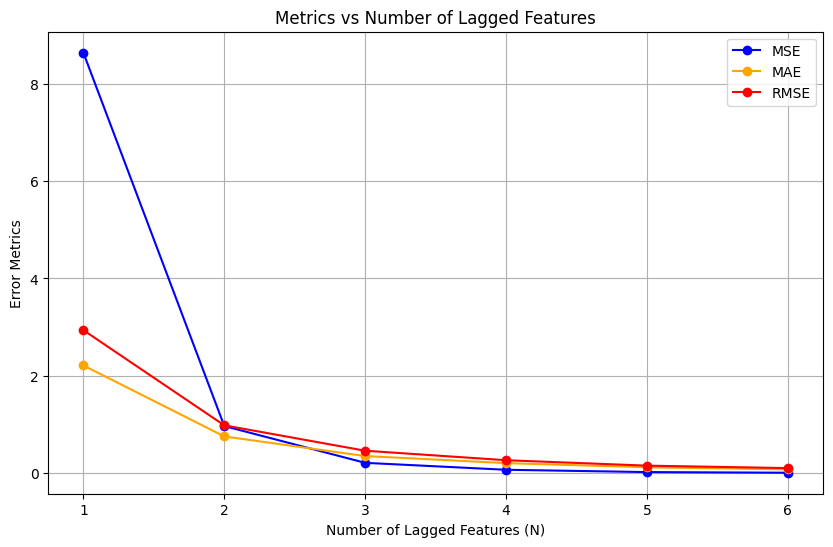

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a function that trains and evaluates the model for different amounts
# of lagged features and different DataFrames
def linear_regression_model(N, data):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training set and validation set
    train_data = data[data['Date'] < '2024-01-01']  # Use previous years for training
    validation_data = data[data['Date'] >= '2024-01-01']  # Use year 2024 for validation

    # Prepare features (X) and target (y) for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    # Create and fit the Linear Regression model using the training set
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make the prediction using the validation set
    y_pred = model.predict(X_val)

    # Evaluate the model metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mse = mean_squared_error(y_val, y_pred)

    # Get model parameters (weights and bias)
    weights = model.coef_
    bias = model.intercept_

    return mae, rmse, mse, y_val, y_pred, validation_data['Date'], weights, bias

# Plot the actual and predicted 'close' prices for the different values of lagged features and
# the initial DataFrame
num_tests = 6  # Testing from N = 1 to 6
fig, axes = plt.subplots(num_tests, 1, figsize=(14, 5 * num_tests))
results = []

for idx, N in enumerate(range(1, num_tests + 1)):
    mae, rmse, mse, y_val, y_pred, dates, weights, bias = linear_regression_model(N, df)  # Call the function here
    results.append((N, mae, rmse, mse))

    axes[idx].plot(dates, y_val, label='Actual', color='blue', linewidth=2)
    axes[idx].plot(dates, y_pred, label='Predicted', color='orange', linewidth=2)
    axes[idx].set_title(f'Actual vs Predicted Closing Prices (N={N})')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Close Price')
    axes[idx].legend()
    axes[idx].grid(True)

    # Print the model coefficients
    print(f"\nModel Parameters for N={N}:")
    print(f"Bias: {bias:.4f}")
    equation = f"Close_t = {bias:.4f}"
    for i, coef in enumerate(weights):
        equation += f" + ({coef:.4f}) * close_t-{i+1}"
        print(f"Weight for close_t-{i+1}: {coef:.4f}")
    print("Model Equation:")
    print(equation)

results_df = pd.DataFrame(results, columns=['N', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error'])
print('\nMetrics')
print(results_df)

plt.tight_layout()
plt.show()

# Plot Metrics vs Number of Lagged Features
plt.figure(figsize=(10, 6))
mse_values = results_df['Mean Squared Error']
mae_values = results_df['Mean Absolute Error']
rmse_values = results_df['Root Mean Squared Error']

plt.plot(range(1, num_tests + 1), mse_values, marker='o', linestyle='-', color='blue', label='MSE')
plt.plot(range(1, num_tests + 1), mae_values, marker='o', linestyle='-', color='orange', label='MAE')
plt.plot(range(1, num_tests + 1), rmse_values, marker='o', linestyle='-', color='red', label='RMSE')

plt.title('Metrics vs Number of Lagged Features')
plt.xlabel('Number of Lagged Features (N)')
plt.ylabel('Error Metrics')
plt.xticks(range(1, num_tests + 1))
plt.legend()
plt.grid(True)
plt.show()

###**Observation**
By using 1 or 2 lagged features we can see that the prediction is quite good but gives a significant MSE.The same goes for 3-4 lagged features but with a lower Error Metric compared to 1 and 2. Thus, the ideal amount of lagged features is around 5-6, since all the Error Metrics are really close to 0 during the validation process and the predictions seem to be almost exactly the same as the real values. This means that with 5-6 features the model can be trained really efficiently and the usage of more lagged features (probably 10 or even more) could lead to overfitting.

So, we will use this version of the Linear Regression Model with 6 lagged features in order to predict the TSLA stock closing prices from 2024-11-01 until 2024-11-24.

         Date  Predicted Close
0  2024-11-01       252.416341
1  2024-11-02       253.505605
2  2024-11-03       255.664375
3  2024-11-04       258.894451
4  2024-11-05       263.229660
5  2024-11-06       268.461158
6  2024-11-07       273.984307
7  2024-11-08       278.953409
8  2024-11-09       282.654959
9  2024-11-10       284.826274
10 2024-11-11       285.698375
11 2024-11-12       285.765850
12 2024-11-13       285.484895
13 2024-11-14       285.118520
14 2024-11-15       284.793121
15 2024-11-16       284.649852
16 2024-11-17       284.917112
17 2024-11-18       285.827577
18 2024-11-19       287.454977
19 2024-11-20       289.619008
20 2024-11-21       291.947552
21 2024-11-22       294.055135
22 2024-11-23       295.708714
23 2024-11-24       296.873710


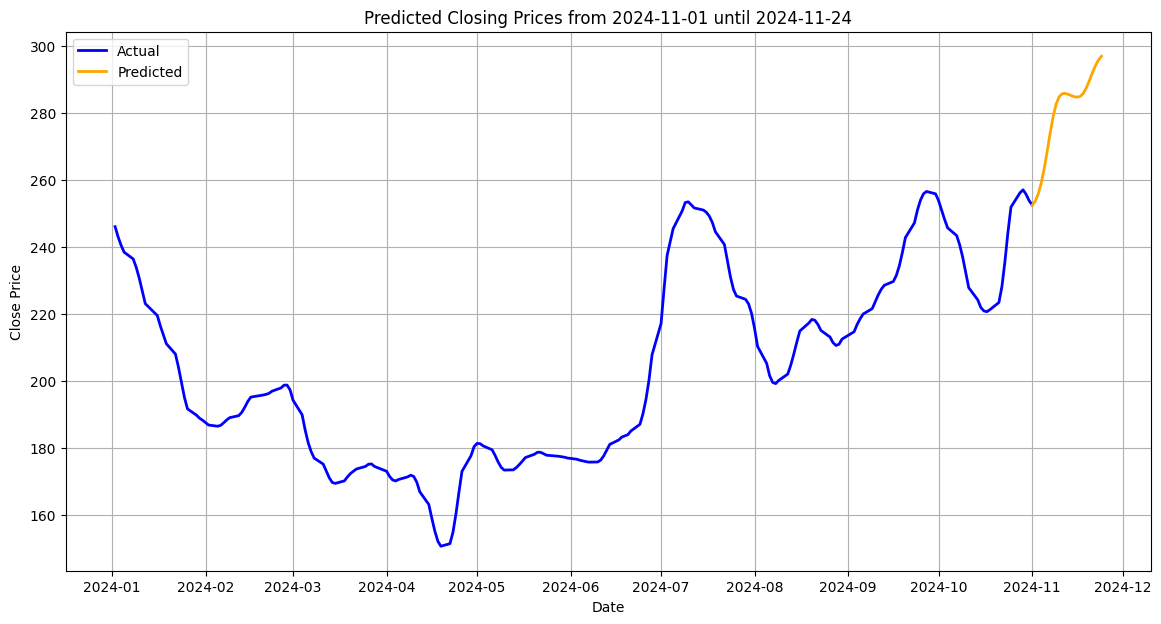

<Figure size 640x480 with 0 Axes>

In [19]:
# Function to predict close prices for new dates
def predict_close_price(df, weights, bias, start_date, num_days):
    predictions = []
    last_known_dates = df['Date'].values # Last known dates
    last_known_prices = df['Close'].values # Last known 'close' prices

    # Get the last N close prices for initial prediction
    last_n_prices = last_known_prices[-N:]

    for _ in range(num_days):
        # Calculate predicted close price for the next day
        predicted_close = np.dot(last_n_prices[::-1], weights) + bias # Put the lagged features in the equation of the model and make the prediction
        predictions.append(predicted_close)

        # Update the last N prices for the next prediction
        last_n_prices = np.append(last_n_prices[1:], predicted_close)  # Shift prices

    return predictions

# Train the model with the best value of lagged features, which is N=6
N = 6
_, _, _, _, _, _, weights, bias = linear_regression_model(N, df)

# Make predictions starting from '2024-11-01' until '2024-11-24'
start_date = '2024-11-01'
num_days = 24
predicted_prices = predict_close_price(df, weights, bias, start_date, num_days)

# Create a DataFrame for predicted prices with corresponding dates
predicted_dates = [pd.to_datetime(start_date) + pd.Timedelta(days=i) for i in range(num_days)]
predictions_df = pd.DataFrame({'Date': predicted_dates, 'Predicted Close': predicted_prices})
print(predictions_df)

# Filter to keep only predictions for the year 2024
predictions_df = predictions_df[predictions_df['Date'].dt.year == 2024]

# Combine predictions with the initial DataFrame
df_combined = pd.concat([df, predictions_df], ignore_index=True)

# Plot the actual and predicted 'close' prices for November 2024
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df[df['Date'].dt.year == 2024]['Date'], df[df['Date'].dt.year == 2024]['Close'], label='Actual', color='blue', linewidth=2)
ax.plot(predictions_df['Date'], predictions_df['Predicted Close'], label='Predicted', color='orange', linestyle='-', linewidth=2)
ax.set_title('Predicted Closing Prices from 2024-11-01 until 2024-11-24')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
ax.grid(True)
plt.show()

plt.tight_layout()
plt.show()

###**Real TSLA stock closing prices until November 24th**

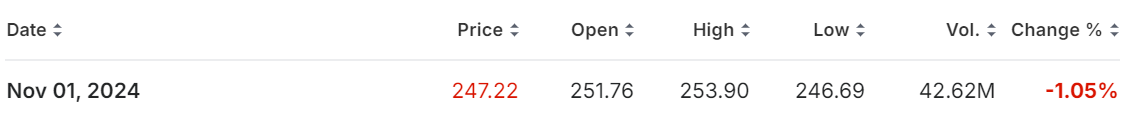

##**Using weekly average closing prices as lagged features**


Model Parameters for N=1:
Bias: 12.0909
Weight for weekly_avg_t-1: 0.9717
Model Equation:
Weekly_Avg_Close_t = 12.0909 + (0.9717) * weekly_avg_t-1

Model Parameters for N=2:
Bias: 16.4751
Weight for weekly_avg_t-1: 1.3330
Weight for weekly_avg_t-2: -0.3717
Model Equation:
Weekly_Avg_Close_t = 16.4751 + (1.3330) * weekly_avg_t-1 + (-0.3717) * weekly_avg_t-2

Model Parameters for N=3:
Bias: 11.7034
Weight for weekly_avg_t-1: 1.4438
Weight for weekly_avg_t-2: -0.7689
Weight for weekly_avg_t-3: 0.2978
Model Equation:
Weekly_Avg_Close_t = 11.7034 + (1.4438) * weekly_avg_t-1 + (-0.7689) * weekly_avg_t-2 + (0.2978) * weekly_avg_t-3

Model Parameters for N=4:
Bias: 13.0800
Weight for weekly_avg_t-1: 1.4805
Weight for weekly_avg_t-2: -0.8637
Weight for weekly_avg_t-3: 0.4757
Weight for weekly_avg_t-4: -0.1231
Model Equation:
Weekly_Avg_Close_t = 13.0800 + (1.4805) * weekly_avg_t-1 + (-0.8637) * weekly_avg_t-2 + (0.4757) * weekly_avg_t-3 + (-0.1231) * weekly_avg_t-4

Model Parameters for N=5:
B

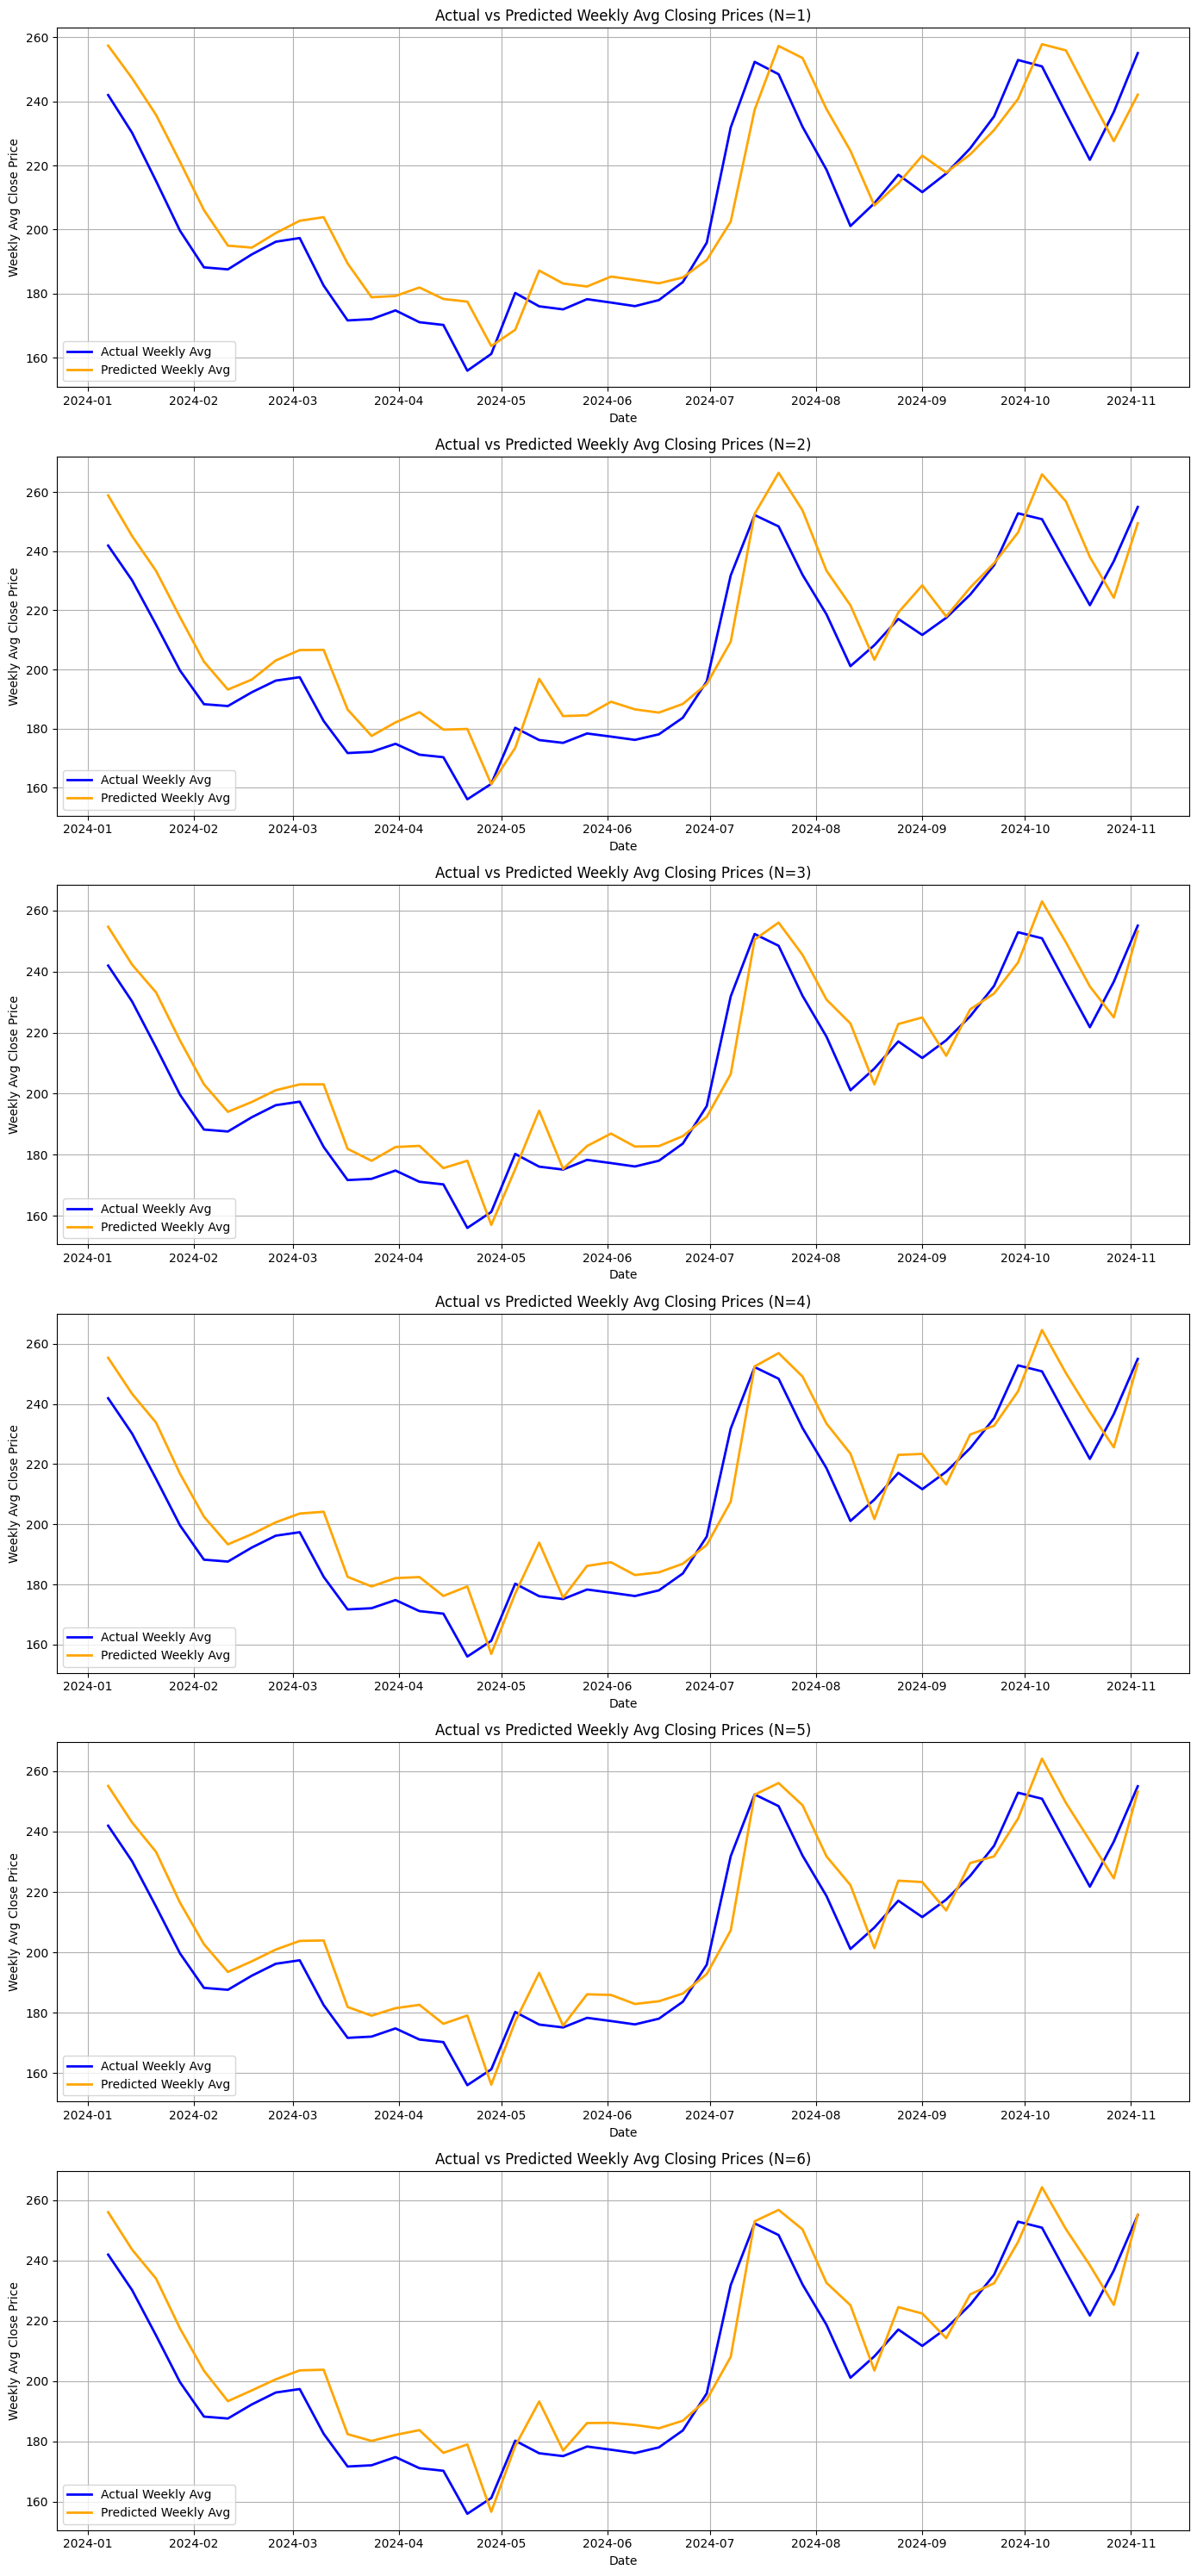

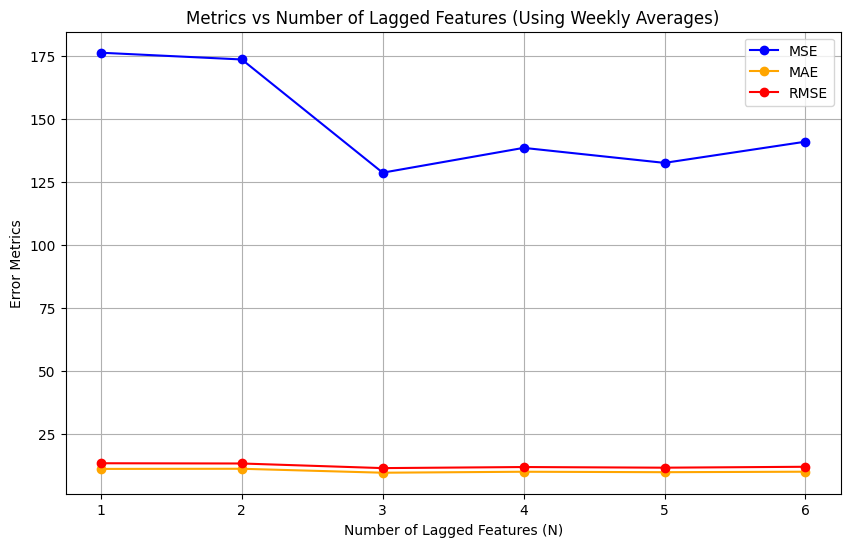

In [20]:
# Define a function to train the model using weekly averages as lagged features
def linear_regression_model(N, data):
    # Create N lagged features using weekly averages
    for i in range(1, N + 1):
        data[f'weekly_avg_t-{i}'] = data['Weekly_Avg_Close'].shift(i)

    # Drop NaN values after creating lagged features
    data.dropna(inplace=True)

    # Split data into training (before 2024) and validation sets (2024)
    train_data = data[data['Date'] < '2024-01-01']
    validation_data = data[data['Date'] >= '2024-01-01']

    # Prepare features (X) and target (y) for training and validation
    X_train = train_data[[f'weekly_avg_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Weekly_Avg_Close']
    X_val = validation_data[[f'weekly_avg_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Weekly_Avg_Close']

    # Train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions for validation
    y_pred = model.predict(X_val)

    # Evaluate model performance
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mse = mean_squared_error(y_val, y_pred)

    # Get model parameters
    weights = model.coef_
    bias = model.intercept_

    return mae, rmse, mse, y_val, y_pred, validation_data['Date'], weights, bias

# Plot the actual and predicted 'close' prices using different values of lagged features
num_tests = 6  # Testing from N = 1 to 6
fig, axes = plt.subplots(num_tests, 1, figsize=(14, 5 * num_tests))
results = []

for idx, N in enumerate(range(1, num_tests + 1)):
    mae, rmse, mse, y_val, y_pred, dates, weights, bias = linear_regression_model(N, weekly_avg)  # Call the function here
    results.append((N, mae, rmse, mse))

    axes[idx].plot(dates, y_val, label='Actual Weekly Avg', color='blue', linewidth=2)
    axes[idx].plot(dates, y_pred, label='Predicted Weekly Avg', color='orange', linewidth=2)
    axes[idx].set_title(f'Actual vs Predicted Weekly Avg Closing Prices (N={N})')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Weekly Avg Close Price')
    axes[idx].legend()
    axes[idx].grid(True)

    # Print the model coefficients
    print(f"\nModel Parameters for N={N}:")
    print(f"Bias: {bias:.4f}")
    equation = f"Weekly_Avg_Close_t = {bias:.4f}"
    for i, coef in enumerate(weights):
        equation += f" + ({coef:.4f}) * weekly_avg_t-{i+1}"
        print(f"Weight for weekly_avg_t-{i+1}: {coef:.4f}")
    print("Model Equation:")
    print(equation)

results_df = pd.DataFrame(results, columns=['N', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error'])
print('\nMetrics')
print(results_df)

plt.tight_layout()
plt.show()

# Plot Metrics vs Number of Lagged Features
plt.figure(figsize=(10, 6))
mse_values = results_df['Mean Squared Error']
mae_values = results_df['Mean Absolute Error']
rmse_values = results_df['Root Mean Squared Error']

plt.plot(range(1, num_tests + 1), mse_values, marker='o', linestyle='-', color='blue', label='MSE')
plt.plot(range(1, num_tests + 1), mae_values, marker='o', linestyle='-', color='orange', label='MAE')
plt.plot(range(1, num_tests + 1), rmse_values, marker='o', linestyle='-', color='red', label='RMSE')

plt.title('Metrics vs Number of Lagged Features (Using Weekly Averages)')
plt.xlabel('Number of Lagged Features (N)')
plt.ylabel('Error Metrics')
plt.xticks(range(1, num_tests + 1))
plt.legend()
plt.grid(True)
plt.show()

### **Observation**

#**Training, Validation and Testing of Polynomial Regression Model w/ L1-Normalization**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.470e+04, tolerance: 2.792e+04
  model = cd_fast.enet_coordinate_descent(


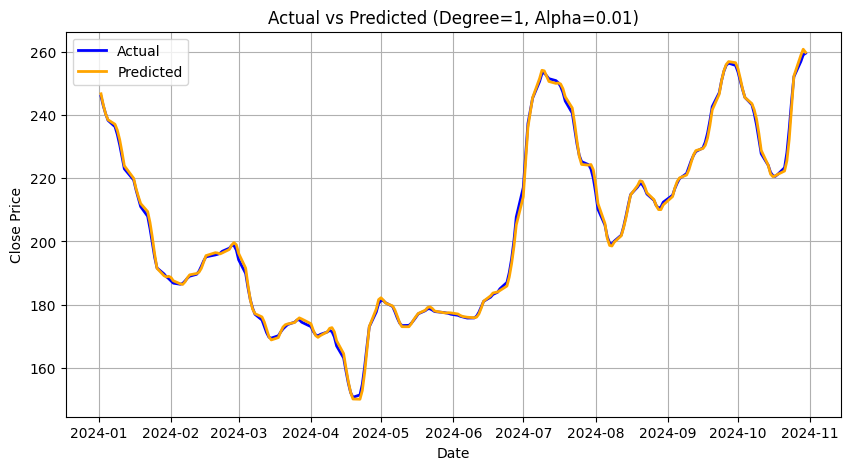

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+04, tolerance: 2.792e+04
  model = cd_fast.enet_coordinate_descent(


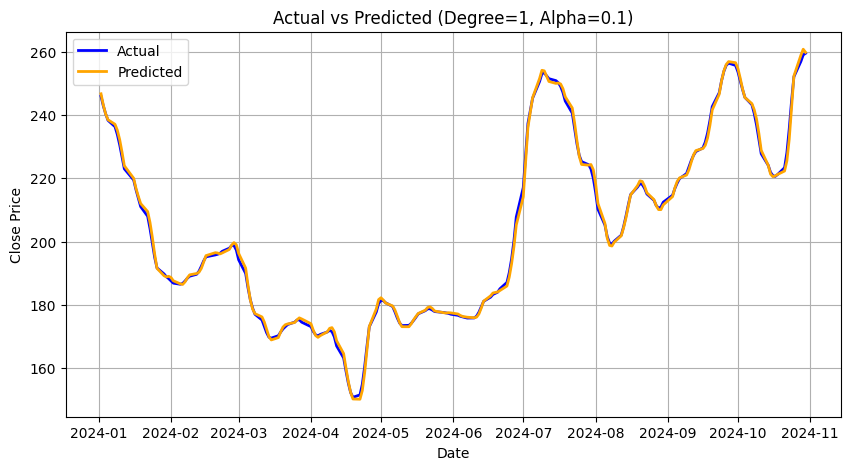

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.402e+04, tolerance: 2.792e+04
  model = cd_fast.enet_coordinate_descent(


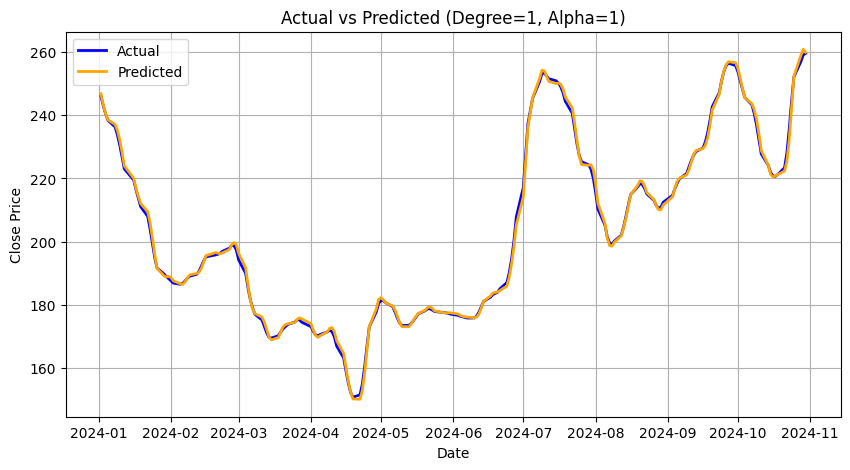

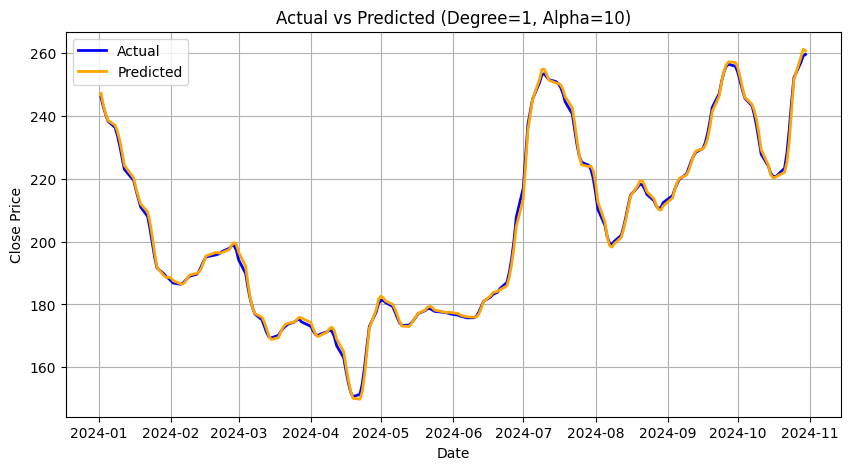

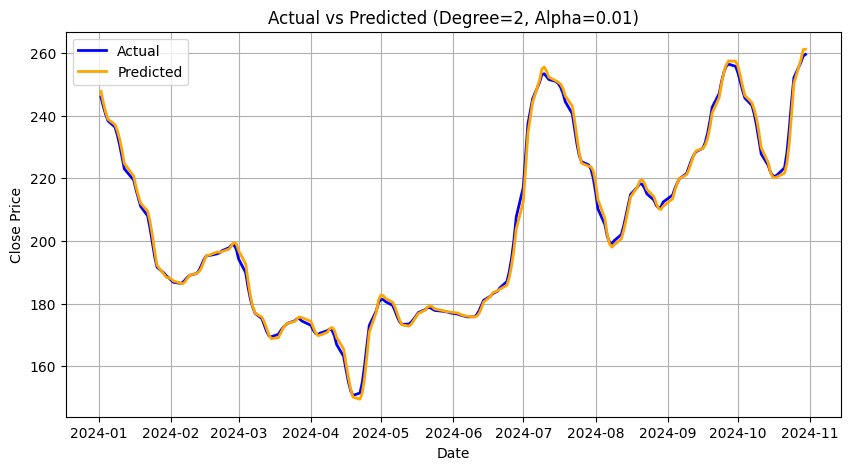

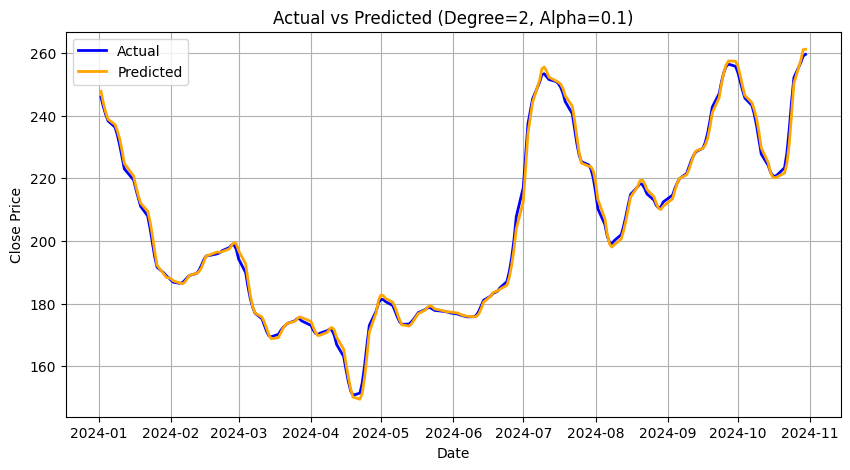

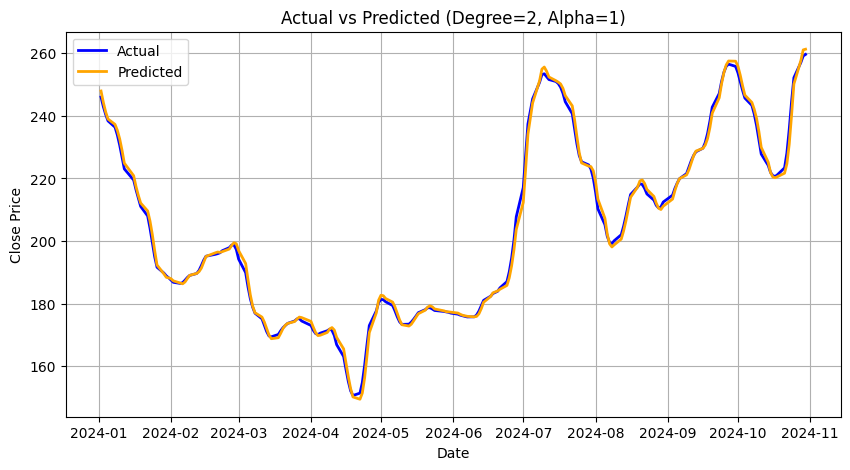

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.654e+04, tolerance: 2.792e+04
  model = cd_fast.enet_coordinate_descent(


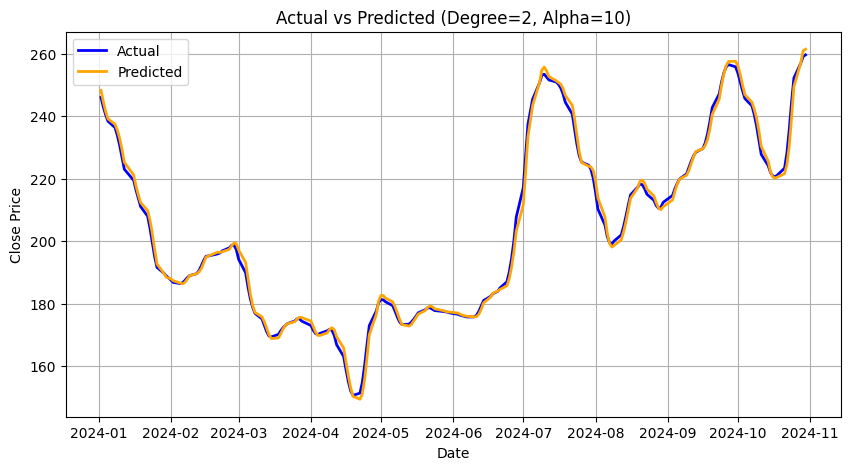

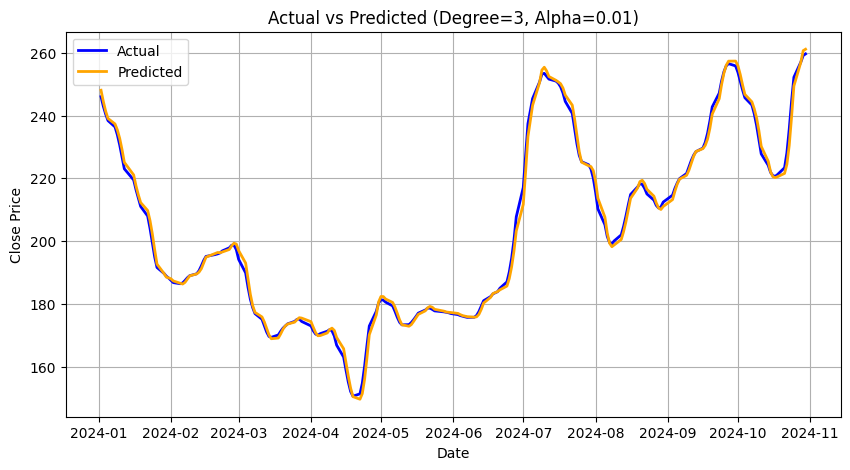

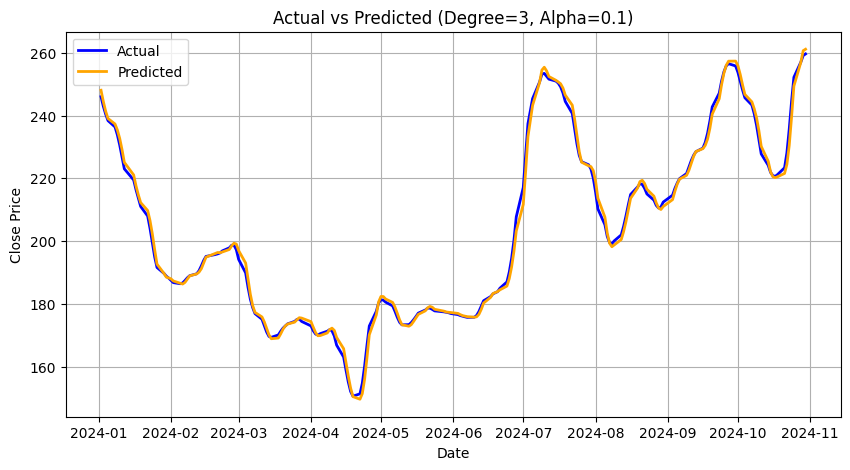

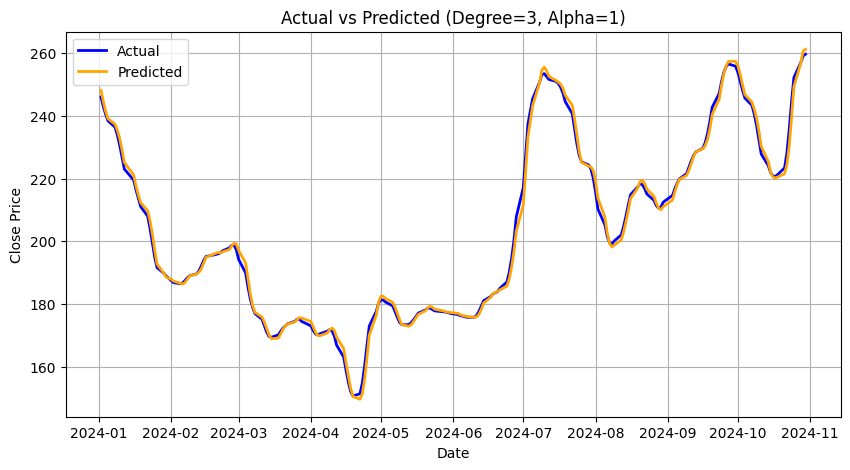

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.281e+04, tolerance: 2.792e+04
  model = cd_fast.enet_coordinate_descent(


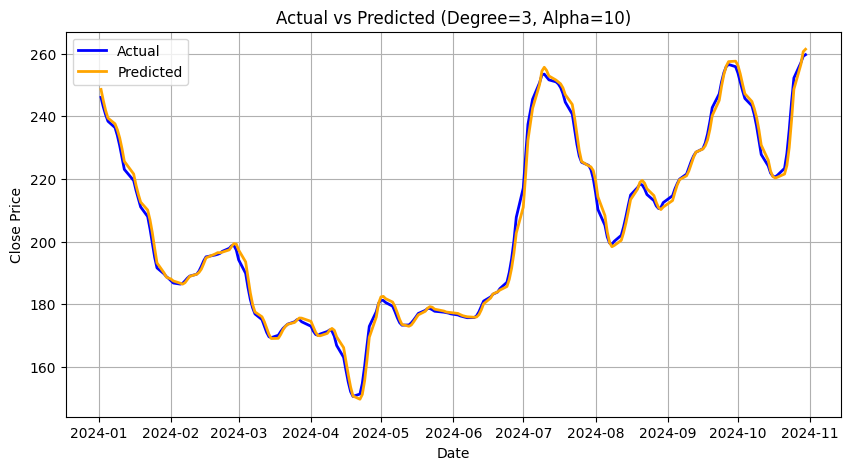

    Model  Degree  Alpha       MSE
0   Lasso       1   0.01  0.941846
1   Lasso       1   0.10  0.944152
2   Lasso       1   1.00  0.967836
3   Lasso       1  10.00  1.345622
4   Lasso       2   0.01  2.113771
5   Lasso       2   0.10  2.129408
6   Lasso       2   1.00  2.283821
7   Lasso       2  10.00  2.965068
8   Lasso       3   0.01  2.726361
9   Lasso       3   0.10  2.740071
10  Lasso       3   1.00  2.864402
11  Lasso       3  10.00  3.701312


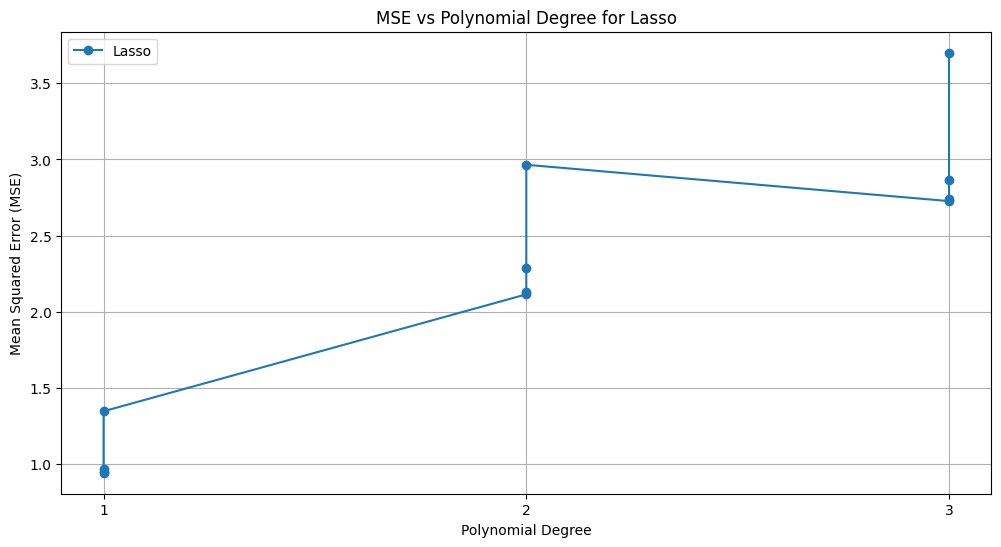

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create a function that trains and evaluates the model for different amounts
# of lagged features and different DataFrames
def L1_polynomial_regression_model(N, data, max_degree=3, alpha_values=[0.01, 0.1, 1, 10]):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training set and validation set
    train_data = data[data['Date'] < '2024-01-01']  # Use previous years for training
    validation_data = data[data['Date'] >= '2024-01-01']  # Use year 2024 for validation

    # Prepare features (X) and target (y) for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    results = []

    # Loop over different polynomial degrees
    for degree in range(1, max_degree + 1):
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_val = poly.transform(X_val)

        # Evaluate Lasso for different alpha values
        for alpha in alpha_values:
            lasso = Lasso(alpha=alpha)
            lasso.fit(X_poly_train, y_train)
            y_pred_lasso = lasso.predict(X_poly_val)
            lasso_mse = mean_squared_error(y_val, y_pred_lasso)
            results.append(('Lasso', degree, alpha, lasso_mse))

            # Plot actual vs predicted for each combination of degree and alpha
            plt.figure(figsize=(10, 5))
            plt.plot(validation_data['Date'], y_val, label='Actual', color='blue', linewidth=2)
            plt.plot(validation_data['Date'], y_pred_lasso, label='Predicted', color='orange', linewidth=2)
            plt.title(f'Actual vs Predicted (Degree={degree}, Alpha={alpha})')
            plt.xlabel('Date')
            plt.ylabel('Close Price')
            plt.legend()
            plt.grid(True)
            plt.show()

    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results, columns=['Model', 'Degree', 'Alpha', 'MSE'])
    print(results_df)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    for model in results_df['Model'].unique():
        subset = results_df[results_df['Model'] == model]
        plt.plot(subset['Degree'], subset['MSE'], marker='o', label=model)

    plt.title('MSE vs Polynomial Degree for Lasso')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.xticks(range(1, max_degree + 1))
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
L1_polynomial_regression_model(6, df)  # Call the function with your DataFrame
